We used the **UCI Ionosphere** dataset, which contains **351 radar returns** described by **34 continuous features**, with a binary label indicating whether a return is **“good” (g)** or **“bad” (b)**. ([UCI Machine Learning Repository][1]) In the notebook, we loaded the data directly from the UCI URL, created a numeric target (`y=1` for *g*, `y=0` for *b*), and prepared the feature matrix `X` (optionally dropping a column that is often treated as non-informative/constant in some versions of this dataset). ([UCI Machine Learning Repository][1]) This gave us a clean supervised-learning setup for a simple binary classifier.

For modeling, we trained a **Logistic Regression** classifier using a preprocessing/training **pipeline** that expands the input with **polynomial features (degree=2)** to capture simple non-linear interactions, then applies **standardization**, and finally fits the logistic model. We evaluated performance on a held-out test split using metrics such as **accuracy, precision, and recall**, and visualized results with a **confusion matrix**. We also explored the idea of **threshold tuning**: instead of using the default 0.5 cutoff, we can pick a higher (or lower) threshold to trade off precision vs. recall—e.g., a very high threshold typically increases precision (fewer false positives) but reduces recall (more false negatives). Finally, ROC/AUC analysis (when included) helps judge how well the model separates the two classes *independently of the chosen threshold*, while the confusion matrix shows what that separation looks like at a specific operating point.


# **Importing & Exploring the Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
cols = [f"f{i}" for i in range(34)] + ["class"]

df = pd.read_csv(url, header=None, names=cols)
df["y"] = (df["class"] == "g").astype(int)   # g=good (1), b=bad (0)
X = df.drop(columns=["class","y"])
y = df["y"]

df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f26,f27,f28,f29,f30,f31,f32,f33,class,y
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 36 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      351 non-null    int64  
 1   f1      351 non-null    int64  
 2   f2      351 non-null    float64
 3   f3      351 non-null    float64
 4   f4      351 non-null    float64
 5   f5      351 non-null    float64
 6   f6      351 non-null    float64
 7   f7      351 non-null    float64
 8   f8      351 non-null    float64
 9   f9      351 non-null    float64
 10  f10     351 non-null    float64
 11  f11     351 non-null    float64
 12  f12     351 non-null    float64
 13  f13     351 non-null    float64
 14  f14     351 non-null    float64
 15  f15     351 non-null    float64
 16  f16     351 non-null    float64
 17  f17     351 non-null    float64
 18  f18     351 non-null    float64
 19  f19     351 non-null    float64
 20  f20     351 non-null    float64
 21  f21     351 non-null    float64
 22  f2

In [ ]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f25,f26,f27,f28,f29,f30,f31,f32,f33,y
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,...,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480,0.641026
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,...,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337,0.480384
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,...,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350,0.000000
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,...,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000,1.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,...,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660,1.000000
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Training the Data**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

pipe1 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=3000))
])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
pipe1.fit(X_train, y_train)


prediction1 = pipe1.predict(X_train)
acc1 = accuracy_score(y_train, prediction1)
prec1 = precision_score(y_train, prediction1)
rec1 = recall_score(y_train, prediction1)
print("train")
print("Accuracy:", acc1)
print("Precision:", prec1)
print("Recall:", rec1)


prediction2 = pipe1.predict(X_test)
acc2 = accuracy_score(y_test, prediction2)
prec2 = precision_score(y_test, prediction2)
rec2 = recall_score(y_test, prediction2)
print("\ntest")
print("Accuracy:", acc2)
print("Precision:", prec2)
print("Recall:", rec2)

train
Accuracy: 0.9928571428571429
Precision: 0.9945054945054945
Recall: 0.9945054945054945

test
Accuracy: 0.9014084507042254
Precision: 0.875
Recall: 0.9767441860465116


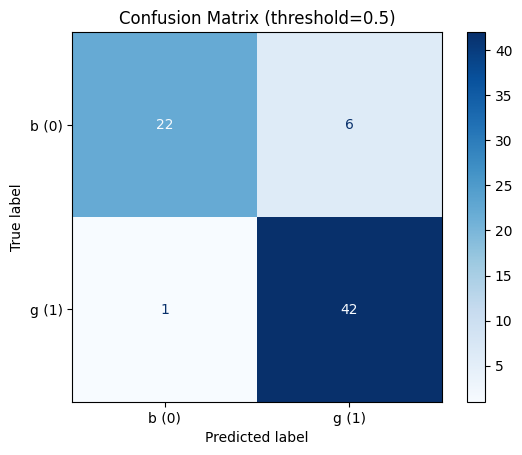

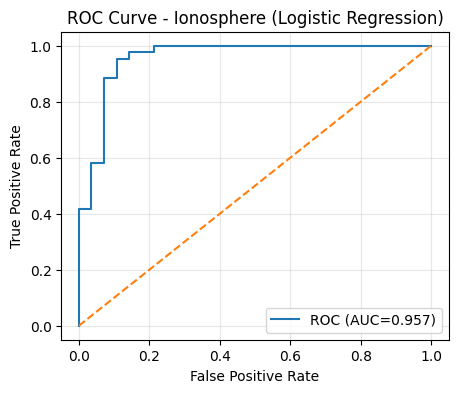

Best threshold (Youden J): 0.9314060086575966


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,roc_curve, roc_auc_score,)


proba = pipe1.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, prediction2)
disp = ConfusionMatrixDisplay(cm, display_labels=["b (0)", "g (1)"])
disp.plot(colorbar='True', cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()

print("\n")

# ROC Curve + AUC
fpr, tpr, thr = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("Actuak=l Positive Rate")
plt.title("ROC Curve - Ionosphere (Logistic Regression)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

j = tpr - fpr
best_thr = thr[np.argmax(j)]
print("Best threshold (Youden J):", best_thr)

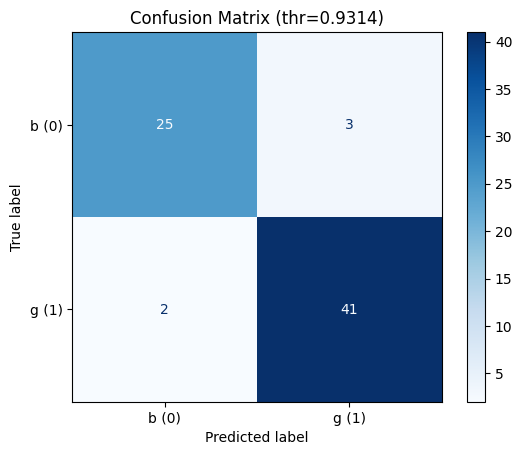

Accuracy: 0.9295774647887324
Precision: 0.9318181818181818
Recall: 0.9534883720930233


In [ ]:
def predict_with_threshold(model, X, thr=0.5):
    p = model.predict_proba(X)[:, 1]
    return (p >= thr).astype(int), p

y_pred_thr, proba = predict_with_threshold(pipe1, X_test, thr=0.9314)


cm2 = confusion_matrix(y_test, y_pred_thr)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=["b (0)", "g (1)"])
disp2.plot(colorbar='True', cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix (thr=0.9314)")
plt.show()

acc3 = accuracy_score(y_test, y_pred_thr)
prec3 = precision_score(y_test, y_pred_thr)
rec3 = recall_score(y_test, y_pred_thr)
print("Accuracy:", acc3)
print("Precision:", prec3)
print("Recall:", rec3)